<a href="https://colab.research.google.com/github/kaiesalmahmud/Leaf_Disease_Detection/blob/main/Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
%%bash
conda install --channel defaults conda python=3.6 --yes
conda update --channel defaults --all --yes

In [ ]:
import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')

In [ ]:
!conda env create -f /content/drive/MyDrive/ML/Naswot/environment.yml

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [ ]:
train_dir = '/content/drive/MyDrive/ML/Leaf Disease Dataset/train'
valid_dir = '/content/drive/MyDrive/ML/Leaf Disease Dataset/val'


dirs = {'train': train_dir, 
        'valid': valid_dir,
       }

In [ ]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomRotation(45),
                                 transforms.RandomResizedCrop(299),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
    ]),

    'valid': transforms.Compose([
                                 transforms.Resize(299),
                                 transforms.CenterCrop(299),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
    ])
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

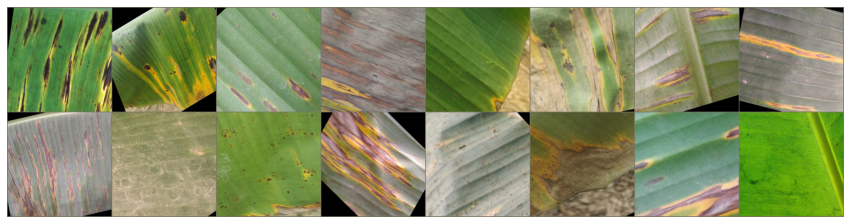

In [ ]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off')
        
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def plot_early_stopping(train_loss, valid_loss):
    """
    train_loss = avg_train_losses : List
    valid_loss = avg_valid_losses : List
    """
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1), train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1), valid_loss, label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
def train(model, lr, num_epoch, train_loader, valid_loader, patience):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, num_epoch + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            
            data = data.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = F.cross_entropy(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:

            data = data.to(device)
            target = target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = F.cross_entropy(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        
        # implement scheduler
        scheduler.step(valid_loss)
        
        
        epoch_len = len(str(num_epoch))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epoch:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print(">>> Early stopping")
            plot_early_stopping(avg_train_losses, avg_valid_losses)
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
del vgg16

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
vgg16.classifier[6] = nn.Linear(4096, 3)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   13675 MB |   13675 MB |     885 GB |     872 GB |\n|       from large pool |   13627 MB |   13627 MB |     883 GB |     869 GB |\n|       from small pool |      48 MB |      49 MB |       2 GB |       2 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |   13675 MB |   13675 MB |     885 GB |     872 GB |\n|       from large pool |   13627 MB |   13627 MB |

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   13675 MB |   13675 MB |     885 GB |     872 GB |\n|       from large pool |   13627 MB |   13627 MB |     883 GB |     869 GB |\n|       from small pool |      48 MB |      49 MB |       2 GB |       2 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |   13675 MB |   13675 MB |     885 GB |     872 GB |\n|       from large pool |   13627 MB |   13627 MB |

In [ ]:
next(vgg16.parameters()).is_cuda

True

In [ ]:
num_epoch = 10
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']
patience = 5

In [ ]:
model, train_loss, valid_loss = train(vgg16, 0.1, 
                                              num_epoch, train_loader, 
                                              valid_loader, patience)

RuntimeError: ignored